### Step1. 600명의 사용자가 9000개의 영화에 대해 평가한 100000개의 평가 데이터가 존재하는 MovieLens100k 데이터셋 다운로드 및 압축해제

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
!unzip -qq /content/ml-25m.zip

--2023-03-11 04:26:52--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 

### Step2. 영화정보와 영화에 대한 평가 데이터를 판다스를 이용하여 저장

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter

ds_movies = pd.read_csv("/content/ml-25m/movies.csv")
ds_ratings = pd.read_csv("/content/ml-25m/ratings.csv")

In [ ]:
ds_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ds_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### Step3. 콘텐츠 기반 필터링을 사용하기 위해서 28가지 장르에 영화를 원핫 벡터로 인코딩

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
genres = cv.fit_transform(ds_movies.genres)

cv.vocabulary_

{'adventure': 1,
 'animation': 2,
 'children': 3,
 'comedy': 4,
 'fantasy': 8,
 'romance': 19,
 'drama': 7,
 'action': 0,
 'crime': 5,
 'thriller': 21,
 'horror': 12,
 'mystery': 16,
 'sci': 20,
 'fi': 9,
 'imax': 13,
 'documentary': 6,
 'war': 22,
 'musical': 15,
 'western': 23,
 'film': 10,
 'noir': 18,
 'no': 17,
 'genres': 11,
 'listed': 14}

In [ ]:
genres = pd.DataFrame(
    genres.toarray(),
    columns=list(sorted(cv.vocabulary_.keys(), key=lambda x: cv.vocabulary_[x]))
)
genres

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
62419,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62420,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
62421,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


이렇게 하면 각 영화마다 장르별 특성을 기준으로 각각 영화에 대한 유사도를 계산할 수 있다.
유사도를 계산하는 방법으로는
1. 유클리디언 거리
2. 코사인 유사도
3. 피어슨 유사도 등이 있음.

In [ ]:
import numpy as np
# 0번째 영화와 1번째 영화의 유클리디언 거리를 계산하기
a = genres.iloc[0, :]
b = genres.iloc[1, :]
np.linalg.norm(a-b)

1.4142135623730951

Scikit-Learn의 NearestNeighbors를 이용하여 유사한 장르의 영화를 100개 가져온 뒤정렬

### 사용법
파라미터 algoritm은 ['auto', 'ball_tree', 'kd_tree', 'brute'] 중 하나로 설정할 수 있다.

- Brute force
NN 알고리즘 중 가장 빠른 계산을 수행한다. 그리고 데이터셋의 모든 점의 쌍 사이에서의 거리를 모두 계산을 진행함
N개의 샘플에 D 차원이면 시간은 O[DN^2]이다. 따라서, 작은 데이터 샘플에 대해서 적용하는 것이 좋고 큰 알고리즘의 경우에는 좋지 않다.
- KD Tree
데이터 셋이 크면 비효율적인 Brute Force를 보완하기 위해 다양한 트리 기반의 데이터 구조를 만드는 것이 K-D Tree이다.
기본적인 아이디어는 A와 B가 가깝고 B와 C가 가까우면 A와 C도 가깝다는 논리구조로 계산 비용과정을 줄이는 방식이다.
시간복잡도는 O[DNlog(N)]이거나 더 빠르다.
K 차원의 트리라고 해서 K-dimensional tree 즉, K-D Tree이다.
이 알고리즘은 이진탐색 트리 구조와 비슷해 각 데이터의 구조를 나누는데 매우 빠르다. 그러나 이는 오로지 D < 20인 경우에 빠르고 이보다 더 커지면 "차원의 저주"라고 불리는 비효율성이 발생하게 된다.
- Ball Tree
높은 차원에서 KD Tree가 비효율적임을 극보하기 위해 제시된 알고리즘이 Ball Tree이다.
Cartesian 축으로 구분하는 KD Tree와 달리 Ball Tree는 Nesting hyper-spheres로 데이터를 구분하기에 더 비용이 들지만 높은 차원의 데이터셋을 구분하는데 매우 효율적이다.
기본적인 아이디어는 중심 C와 지름 r이 있을 경우 아래의 수식을 기준으로 가까운 이웃을 찾게 된다.


nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)  
distances, indices = nbrs.kneighbors(X)

In [ ]:
from sklearn.neighbors import NearestNeighbors

# n_neighbors: 가장 가까운 n개의 이웃을 찾도록 지정합니다.
nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(genres)
nbrs

NearestNeighbors(algorithm='ball_tree', n_neighbors=100)

### 추천받을 유저가 좋아하는 영화의 정보를 기준으로 100개의 최근접 이웃 모델을 생성

In [ ]:
user = genres.iloc[3, :]
distances, indexes = nbrs.kneighbors([user])
recommendations = ds_movies.loc[indexes[0], ["title"]]
recommendations["distance"] = distances[0]
recommendations

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,title,distance
3227,Mifune's Last Song (Mifunes sidste sang) (1999),0.0
4346,Jump Tomorrow (2001),0.0
3168,Singles (1992),0.0
4252,How to Marry a Millionaire (1953),0.0
1415,Fools Rush In (1997),0.0
...,...,...
2587,Finding North (1998),0.0
3117,Fast Times at Ridgemont High (1982),0.0
3006,Shampoo (1975),0.0
3307,Turtle Diary (1985),0.0


In [ ]:
# 영화별로 평점과 평점개수를 계산합니다
ratings_mean_count = ds_ratings.groupby("movieId").agg({"rating": ["mean", "count"]})
ratings_mean_count.columns = ["ratings_mean", "ratings_count"]
# 평점은 소수점 1자리에서 반올림해줍니다.
ratings_mean_count.ratings_mean = ratings_mean_count.ratings_mean.round(1)
ratings_mean_count

,ratings_mean,ratings_count
movieId,,
1,3.9,57309
2,3.3,24228
3,3.1,11804
4,2.9,2523
5,3.1,11714
...,...,...
209157,1.5,1
209159,3.0,1
209163,4.5,1


In [ ]:
# 기존 추천 데이터에 합쳐줍니다
recommendations = pd.merge(recommendations, ratings_mean_count, left_index=True, right_index=True, how="left")
# 거리순에 이은 평점, 평점수 순으로 정렬해줍니다.
recommendations.sort_values(["distance", "ratings_mean", "ratings_count"], ascending=[True, False, False], inplace=True)
recommendations

,title,distance,ratings_mean_x,ratings_count_x,ratings_mean_y,ratings_count_y,ratings_mean,ratings_count
1203,Harold and Maude (1971),0.0,4.2,16569.0,4.2,16569.0,4.2,16569.0
1214,"Graduate, The (1967)",0.0,4.1,36357.0,4.1,36357.0,4.1,36357.0
1204,Trust (1990),0.0,4.1,13173.0,4.1,13173.0,4.1,13173.0
3468,Bossa Nova (2000),0.0,4.1,4279.0,4.1,4279.0,4.1,4279.0
1147,Delicatessen (1991),0.0,4.1,3576.0,4.1,3576.0,4.1,3576.0
...,...,...,...,...,...,...,...,...
3227,Mifune's Last Song (Mifunes sidste sang) (1999),0.0,1.9,11.0,1.9,11.0,1.9,11.0
3437,Keeping the Faith (2000),0.0,1.7,150.0,1.7,150.0,1.7,150.0
221,Don Juan DeMarco (1995),0.0,NaN,NaN,NaN,NaN,NaN,NaN
3366,Modern Times (1936),0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.decomposition import PCA

genre_decomposed = PCA(n_components=2).fit_transform(genres)
genre_decomposed.shape

(62423, 2)

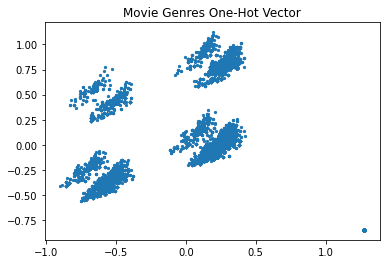

In [ ]:
import matplotlib.pyplot as plt

plt.title("Movie Genres One-Hot Vector")
plt.scatter(genre_decomposed[:, 0], genre_decomposed[:, 1], 5)
plt.show()